In [2]:
import os
import sys
from pathlib import Path

SRC_PATH = Path(__name__).resolve().parents[1]

sys.path.append(str(SRC_PATH))

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from data_generator.pmu import VirtualPMU

In [3]:
pmu = VirtualPMU(sample_rate=60, event_rate=1.0, error_rate=0.02)

In [4]:
df = pmu.create_dataframe(duration=10)

In [5]:
df["label_name"].unique()

array(['Normal', 'voltage_surge', 'voltage_voltage oscilation',
       'frequency_drops', 'frequency_spike', 'phase_angle_shift',
       'frequency_high oscilation', 'frequency_low oscilation'],
      dtype=object)

In [6]:
df.reset_index(drop=True, inplace=True)

In [7]:
df.describe()

,timestamp,frequency,voltage,current,phase_angle,label
count,600,582.000000,587.000000,593.000000,584.000000,600.000000
mean,2024-10-02 19:06:58.294117120,59.997635,1.000791,0.951089,0.005746,0.166667
min,2024-10-02 19:01:58.794117,59.554083,0.674547,0.907928,-0.044570,0.000000
25%,2024-10-02 19:04:28.544117248,59.992183,0.989720,0.941005,-0.008739,0.000000
50%,2024-10-02 19:06:58.294117120,60.000430,1.000792,0.951123,0.000027,0.000000
75%,2024-10-02 19:09:28.044116992,60.007960,1.012705,0.960959,0.011479,0.000000
max,2024-10-02 19:11:57.794117,60.450248,1.320690,0.999958,0.325535,1.000000
std,NaN,0.074222,0.058450,0.014849,0.041811,0.372989


In [8]:
print("\nMissing Values Count by Column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])


Missing Values Count by Column:
frequency      18
voltage        13
current         7
phase_angle    16
dtype: int64



Visualizing Missing Values...


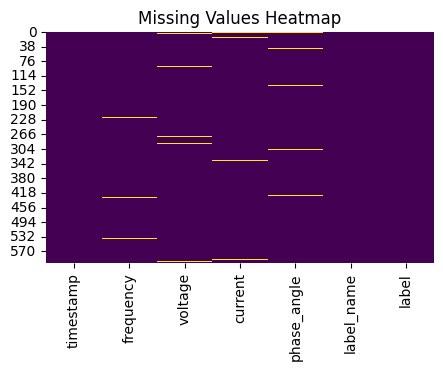

In [9]:
print("\nVisualizing Missing Values...")
plt.figure(figsize=(5, 3))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

### Analysis

- No Categorical Features have been included.
- frequency, voltage, current, phase_angle
    - Mean - 59.999843, 0.999991,	0.949996, 0.013378,
    - Std - 0.021878, 0.014863, 0.009005, 0.707026
- Frequency, Voltage, Current have small standard deviations but phase angle is quite spread.

- Typically, there are 1000 over missing value, but we can handle simple impuation forward fill and backfill because generally the features have small spread.

In [10]:
class MissingHandler(object):
    def handle_missing_values(self, data_frame):
        """Fill missing values."""
        return data_frame.ffill().bfill()

In [11]:
missing_handler = MissingHandler()

pmu_data = missing_handler.handle_missing_values(df)

In [12]:
print("\nMissing Values Count by Column:")
missing_values = pmu_data.isnull().sum()
print(missing_values[missing_values > 0])


Missing Values Count by Column:
Series([], dtype: int64)


In [13]:
pmu_data["label"].value_counts()

label
0    500
1    100
Name: count, dtype: int64

In [14]:
pmu_data["label_name"].value_counts()

label_name
Normal                        500
voltage_voltage oscilation     20
frequency_high oscilation      20
frequency_low oscilation       20
frequency_drops                10
voltage_surge                  10
phase_angle_shift              10
frequency_spike                10
Name: count, dtype: int64

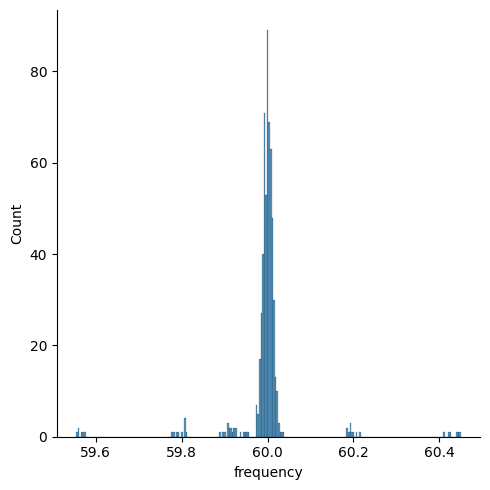

In [15]:

sns.displot(pmu_data["frequency"])

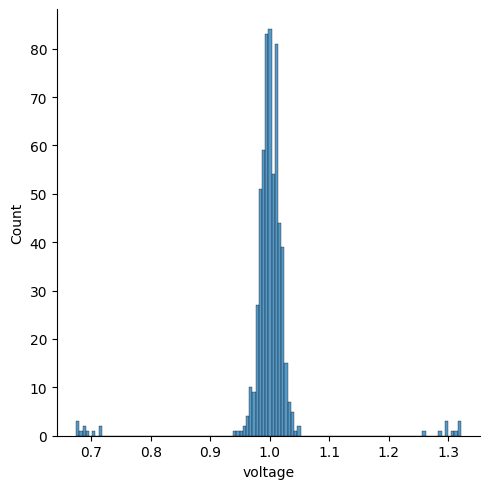

In [16]:

sns.displot(pmu_data["voltage"])

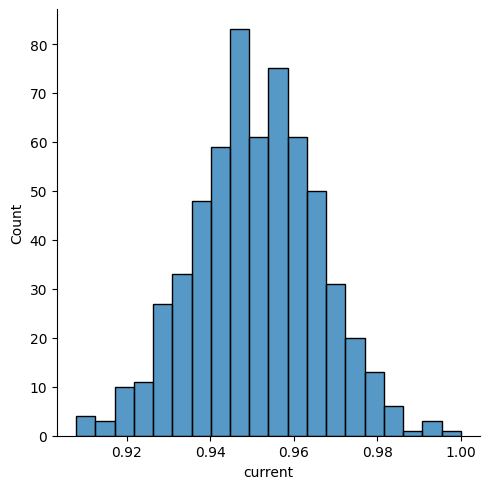

In [17]:
sns.displot(pmu_data["current"])

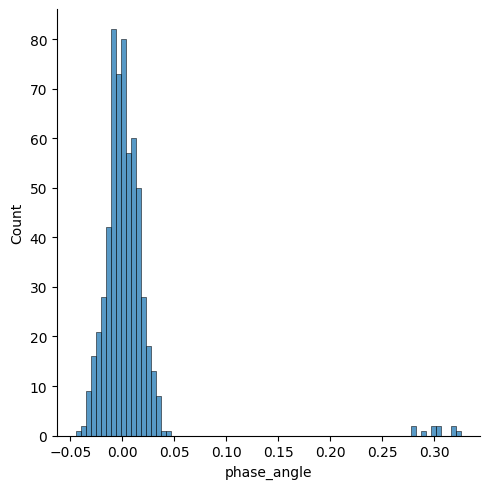

In [18]:
sns.displot(pmu_data["phase_angle"])

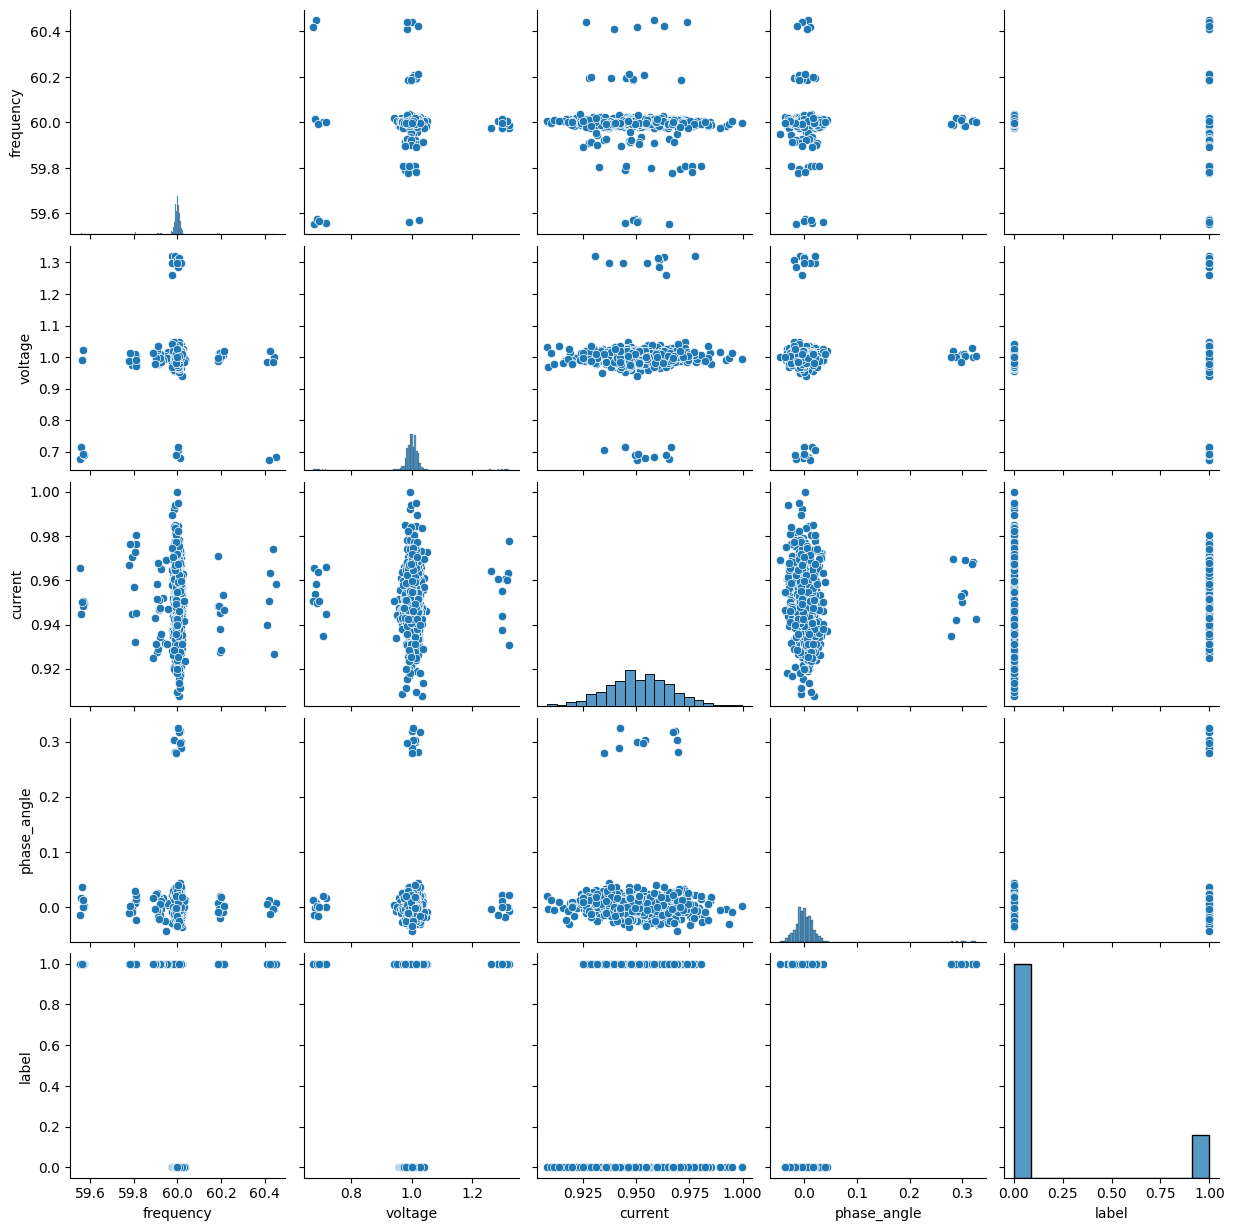

In [19]:
sns.pairplot(pmu_data.drop(labels=["timestamp", "label_name"], axis=1))

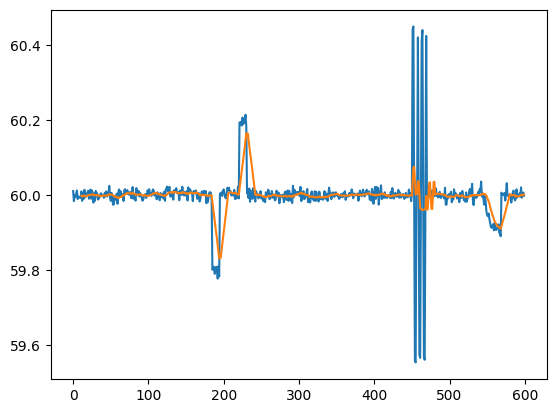

In [20]:

plt.plot(pmu_data["frequency"][:2000])
plt.plot(pmu_data["frequency"].rolling(12).mean().dropna()[:2000])

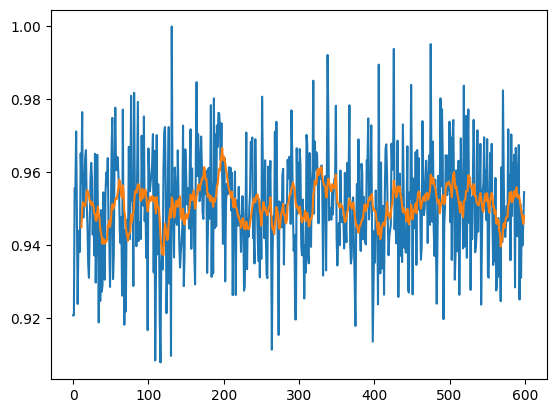

In [21]:

plt.plot(pmu_data["current"][:2000])
plt.plot(pmu_data["current"].rolling(12).mean().dropna()[:2000])

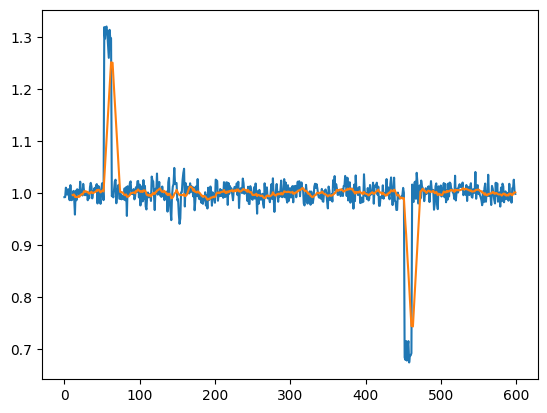

In [22]:

plt.plot(pmu_data["voltage"][:2000])
plt.plot(pmu_data["voltage"].rolling(12).mean().dropna()[:2000])

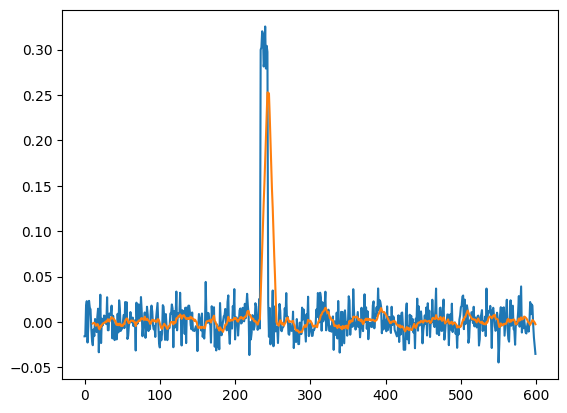

In [23]:

plt.plot(pmu_data["phase_angle"][:2000])
plt.plot(pmu_data["phase_angle"].rolling(12).mean().dropna()[:2000])

In [24]:
from src.detectors import FrequencyDetector, TKEODetector, ZscoreDetector, ROCOFDetector

In [26]:
fr_detector = FrequencyDetector()

fr_anomailes = fr_detector.detect(pmu_data["frequency"].values)

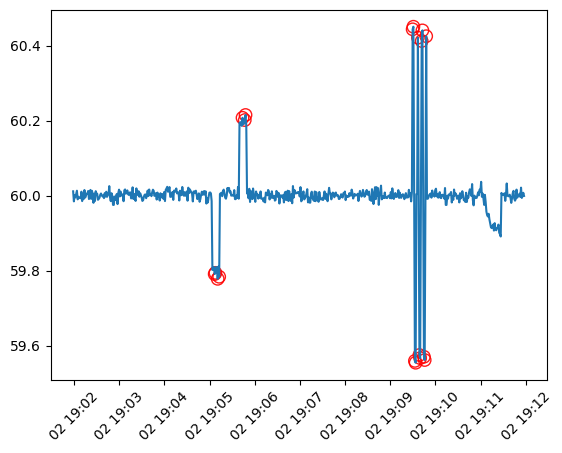

In [45]:
fig, ax = plt.subplots()

ax.plot(pmu_data["timestamp"], pmu_data["frequency"].values)
ax.scatter(pmu_data["timestamp"][fr_anomailes], pmu_data["frequency"][fr_anomailes].values, s=80, facecolors='none', edgecolors='red', alpha=0.9)
plt.xticks(rotation=45)

In [57]:
true_frequencies = pmu_data[pmu_data["label_name"].str.startswith("frequency")]



In [87]:
tkeo_detector = TKEODetector()

tkeo_fr_anomailes = tkeo_detector.detect(pmu_data["frequency"].values, threshold=2.5)

In [88]:
tkeo_ = TKEODetector.teager_kaiser_energy_operator(pmu_data["frequency"].values)

In [89]:
tkeo_.std()

5.374785077310667

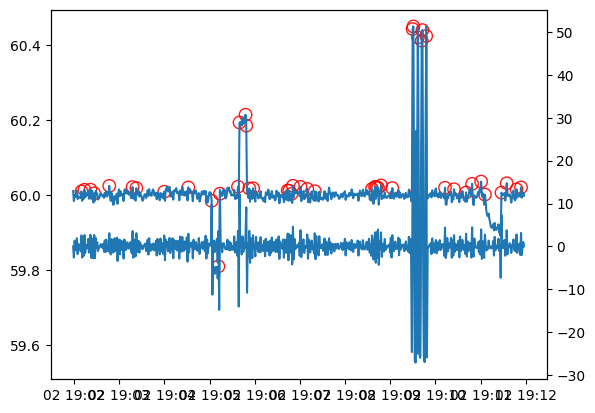

In [90]:
fig, ax = plt.subplots()

ax.plot(pmu_data["timestamp"], pmu_data["frequency"].values)
ax2 = ax.twinx()
ax2.plot(pmu_data["timestamp"], tkeo_)
ax.scatter(pmu_data["timestamp"][tkeo_fr_anomailes], pmu_data["frequency"][tkeo_fr_anomailes].values, s=80, facecolors='none', edgecolors='red', alpha=0.9)
# plt.xticks(rotation=45)